In [3]:
#import Library
!pip install emoji
!pip install textblob
!pip install nltk
!pip install Distance
!pip install fuzzywuzzy
!pip install ginsim
!pip install ydata_profiling
! pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for Distance: filename=Distance-0.1.3-py3-none-any.whl size=16257 sha256=91636308a95fe1a3369385fc7926ff495bf970ce32799e2c880c2609c0d1279a
  Stored in directory: /root/.cache/pip/wheels/e8/bb/de/f71bf63559ea9a921059a5405806f7ff6ed612a9231c4a9309
Successfully built Distance
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.2/356.2 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 91.5 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any

In [4]:
import os
#basic library
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#text preprocessing library
from bs4 import BeautifulSoup
import string
import emoji
from textblob import TextBlob
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#feature extraction library
import distance
from fuzzywuzzy import fuzz
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
import optuna

#Model building library
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

#Model evaluation library
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,r2_score

#load model
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [5]:
import ydata_profiling as yp
from ydata_profiling import ProfileReport

In [7]:
#Data Extraction
df=pd.read_csv('/content/sample_data/Query.csv')

In [8]:
profile = ProfileReport(df,title='Query_pair_analysis_report')
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
#as per y_data analysis we have to take care of null values and imbalance data as well
df.isnull().sum()
df.dropna(inplace=True) # we have very less null data
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

<Axes: xlabel='is_duplicate'>

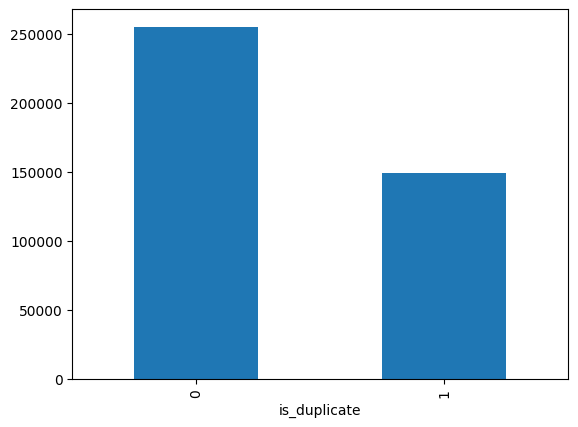

In [10]:
df['is_duplicate'].value_counts().plot(kind='bar')

In [18]:
print('question1 unique:',df[['question1']].nunique())
print('question2 unique:',df[['question2']].nunique())
print('question1 and question2 common:', len(set(df['question2'].values).intersection(set(df['question1'].values))))

question1 unique: question1    290455
dtype: int64
question2 unique: question2    299173
dtype: int64
question1 and question2 common: 52269


In [ ]:
#we will do upsample after train test split

<Axes: xlabel='is_duplicate'>

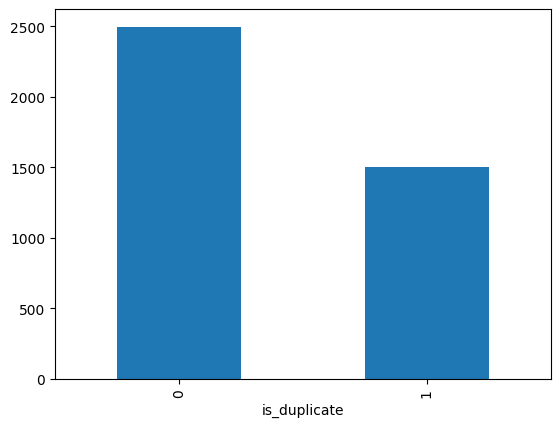

In [19]:
# as we have too much data we will pick top 40Th data point
df=df.sample(4000)
df['is_duplicate'].value_counts().plot(kind='bar')

In [20]:
#Text PreProcessing
def preprocess(quest):
  # Lower case
  quest=str(quest).lower().strip()

  # Remove html tag
  quest=BeautifulSoup(quest)
  quest=quest.get_text()
  #print (quest)
  # replae certain special character with  their equivalents

  quest = quest.replace('%', ' percent')
  quest = quest.replace('$', ' dollar ')
  quest = quest.replace('₹', ' rupee ')
  quest = quest.replace('€', ' euro ')
  quest = quest.replace('@', ' at ')

  # The pattern '[math]' appears around 900 times in the whole dataset, we no meaning
  quest = quest.replace('[math]','')

  # Replacing some number with string equivalents (not perfect, can be done better to account for more cases)

  quest = quest.replace(',000,000,000', 'b ')
  quest = quest.replace(',000,000 ', 'm ')
  quest = quest.replace(',000', 'k')
  quest = re.sub(r'([0-9]+)000000000', r'\1b', quest)
  quest = re.sub(r'([0-9]+)00000', r'\1m', quest)
  quest = re.sub(r'([0-9]+)000', r'\1k',quest)

  # chatword treatment

  # Decontracting words
  # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
  # https://stackoverflow.com/a/19794953
  contractions = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "can not",
  "can't've": "can not have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "i'd": "i would",
  "i'd've": "i would have",
  "i'll": "i will",
  "i'll've": "i will have",
  "i'm": "i am",
  "i've": "i have",
  "isn't": "is not",
  "it'd": "it would",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so as",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there would",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we would",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you would",
  "you'd've": "you would have",
  "you'll": "you will",
  "you'll've": "you will have",
  "you're": "you are",
  "you've": "you have",
  "'ve" : "have",
  "n't" : "not",
  "'re" : "are",
  "'ll" : "will"
  }

  quest_decontracted = []

  for word in quest.split():
    if word in contractions:
	    word = contractions[word]
    quest_decontracted.append(word)

  quest = ' '. join(quest_decontracted)

  #Remove punctuations
  for char in string.punctuation:
    quest=quest.replace(char,'')

  #Remove url # not needed
  #quest = re.compile(r'https?://\S+|www\.\S+').sub('', quest)

  # Remove stop word
  # will not remove stop word as we will use advance feature engineering
  # handling emojis # replace with it's meaning

  quest = emoji.demojize(quest)

  #spell check . No need
  #quest =TextBlob(quest).correct().string
  #print(quest)

  # Tokenization  # not needed

  # Semming   # will use lemmitization

  #lemmitization # not needed
  #lemmatizer = WordNetLemmatizer()
  #quest = ' '.join([lemmatizer.lemmatize(word) for word in quest.split()])

  return quest


In [ ]:
#preprocess("I'm n't aware of <b> Bold</b>  characters 1,000,000,000")

In [21]:
df['question1'] =df['question1'].apply(preprocess)
df['question2'] =df['question2'].apply(preprocess)

In [22]:
df[['question1','question2']]

question1  \
58910   where does the water from the great lakes come...   
125754                   how is first time sex experience   
276807                   what is surgical strike by india   
84391   how worthwhile is the xlri executive postgradu...   
88791   what could be the best preparation for aptitud...   
...                                                   ...   
96062              how to lose face fat and a double chin   
29524               why does metamorpho have a purple arm   
320205  do some liberals really hate trump or are they...   
44790         why is not tesla selling more cars in china   
194174  what happened to civilians captured by surface...   

                                                question2  
58910   where does the water from the great lakes come...  
125754         what is like having sex for the first time  
276807                  why is a surgical strike named so  
84391   how worthwhile is the xlri postgraduate progra...  
88791   when will the kvpy sa aptitude test be held in...  
...                                                   ...  
96062                         how can one reduce face fat  
29524   why does a yellow and black arm bandage indica...  
320205  could donald trump be a democratic plant is he...  
44790       why is not tesla selling more cars in germany  
194174  in economics the terms law principle theory an...  

[4000 rows x 2 columns]

In [23]:
x_train,x_test,y_train,y_test =train_test_split(df[['question1','question2']],df['is_duplicate'],test_size=0.20,random_state=30)

In [24]:
ngram_cv= CountVectorizer(ngram_range=(1,2),max_features=3000)
question = list(x_train['question1']) + list(x_train['question2'])
ngram_cv.fit(question)

CountVectorizer(max_features=3000, ngram_range=(1, 2))

In [25]:
pickle.dump(ngram_cv,open('ngram_cv.pkl','wb'))

In [26]:
print(x_train.shape ,x_test.shape)

(3200, 2) (800, 2)


In [28]:
#Feature  Representation

In [29]:
def common_words(raw):
  q1 = raw['question1']
  q2 = raw['question2']

  w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
  w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))
  return len(w1.intersection(w2)) # length of set intersection words, i.e common words betwen tow question

def total_words(raw):
  q1 = raw['question1']
  q2 = raw['question2']

  w1 = set(map(lambda word: word.lower().strip(), q1.split(' ')))
  w2 = set(map(lambda word: word.lower().strip(), q2.split(' ')))
  return (len(w1) + len(w2))

#Baisc Feature Representation
def basic_features (raw):
  q1 = raw['question1']
  q2 = raw['question2']

  query = [0.0]*7

  query[0]=len(q1)
  query[1]=len(q2)
  query[2]=len(q1.split())
  query[3]=len(q2.split())
  query[4]=common_words(raw)
  query[5]=total_words(raw)
  query[6]=round(common_words(raw)/total_words(raw),2)

  return query

#Token_advance_features
def token_features (raw):
  q1 = raw['question1']
  q2 = raw['question2']

  STOP_WORDS = stopwords.words("english")
  token_features = [0.0]*8  # as we are returing 8 new featuresm to avoiding the missing of data we will define it in advance

  # convert the sentane into tokens:
  q1_tokens = q1.split(' ')
  q2_tokens = q2.split(' ')

  if len(q1_tokens) == 0 or len(q2_tokens) == 0 :
    return token_features

  # Get the non-stopword in Questions
  q1_words =set([word for word in q1_tokens if word not in STOP_WORDS])
  q2_words =set([word for word in q2_tokens if word not in STOP_WORDS])

  # Get te stopwrods in Question
  q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
  q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

  #Get the common pwords from question pair
  common_word_count = len(q1_words.intersection(q2_words))

  #get the common stopwords from question pari
  common_stop_count = len(q1_stops.intersection(q2_stops))

  #get the common Token from Question pair
  common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

  token_features[0] = common_word_count / (min(len(q1_words),len(q2_words)) + 1) # 1 for safe division
  token_features[1] = common_word_count / (max(len(q1_words),len(q2_words)) + 1) # 1 for safe division
  token_features[2] = common_stop_count / (min(len(q1_stops),len(q2_stops)) + 1) # 1 for safe division
  token_features[3] = common_stop_count / (min(len(q1_stops),len(q2_stops)) + 1) # 1 for safe division
  token_features[4] = common_token_count / (min(len(q1_tokens),len(q2_tokens)) + 1) # 1 for safe division
  token_features[5] = common_token_count / (max(len(q1_tokens),len(q2_tokens)) + 1) # 1 for safe division
  # Lastr word of the question is same or not
  token_features[6] = int(q1_tokens[-1]==q2_tokens[-1]) # last word equal
  # First word of the question is same or not
  token_features[7] = int(q1_tokens[0]==q2_tokens[0]) # first word equal

  return token_features

#Length_base_advance_features
def length_features (raw):
  q1 = raw['question1']
  q2 = raw['question2']

  length_features = [0.0]*3

  #Sentance to tokens
  q1_tokens = q1.split()
  q2_tokens = q2.split()

  if len(q1_tokens) == 0 or len(q2_tokens) == 0 :
    return length_features

  # Abs length feature
  length_features[0]  = abs(len(q1_tokens) - len(q2_tokens))

  #Avg length features
  length_features[1] = np.mean(len(q1_tokens) + len(q2_tokens))

  strs = list(distance.lcsubstrings(q1, q2))
  if strs:
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
  else:
    length_features[2] = 0  # Assign a default value if strs is empty

  return length_features

#Fuzzybuzzy_advance_features
def fuzzy_features(raw):
  q1 = raw['question1']
  q2 = raw['question2']

  fuzzy_features = [0.0]*4

  #fuzzy ratio
  fuzzy_features[0] = fuzz.QRatio(q1,q2)

  #fuzzy_partion_ratio
  fuzzy_features[1] = fuzz.partial_ratio(q1,q2)

  #fuzzy_token_sort_ratio
  fuzzy_features[2] = fuzz.token_sort_ratio(q1,q2)

  #token_set_ratio
  fuzzy_features[3] = fuzz.token_set_ratio(q1,q2)

  return fuzzy_features


In [ ]:
'''query1 = x_train.apply(basic_features,axis=1)
query2 = x_train.apply(token_features,axis=1)
query3 = x_train.apply(length_features,axis=1)
query4 = x_train.apply(fuzzy_features,axis=1)

# baisc_feature
df['q1_len'] = list (map(lambda x: x[0],  query1))
df['q2_len'] =list (map(lambda x: x[1], query1))
df['q1_num_words'] =list (map(lambda x: x[2], query1))
df['q2_num_words'] =list (map(lambda x: x[3], query1))
df['word_common'] =list (map(lambda x: x[4], query1))
df['total_words'] =list (map(lambda x: x[5], query1))
df['word_share']  =list (map(lambda x: x[6], query1))

# Token feature
df['cwc_min'] = list(map(lambda x:x[0],query2))
df['cwc_max'] = list(map(lambda x:x[1],query2))
df['csc_min'] = list(map(lambda x:x[2],query2))
df['csc_max'] = list(map(lambda x:x[3],query2))
df['ctc_min'] = list(map(lambda x:x[4],query2))
df['ctc_max'] = list(map(lambda x:x[5],query2))
df['last_word_equal'] = list(map(lambda x:x[6],query2))
df['first_word_equal'] = list(map(lambda x:x[7],query2))

# length_features
df['abs_len_diff'] = list(map(lambda x: x[0], query3))
df['mean_len'] = list(map(lambda x:x[1], query3))
df['longest_substr_ratio'] = list(map(lambda x: x[2],query3))

# fuzzy_features
df['QRatio'] = list(map(lambda x:x[0], query4))
df['partial_ratio'] = list(map(lambda x: x[1],query4))
df['token_sort_ratio'] = list(map(lambda x: x[2],query4))
df['token_set_ratio'] = list(map(lambda x: x[3],query4))
'''

"query1 = x_train.apply(basic_features,axis=1)\nquery2 = x_train.apply(token_features,axis=1)\nquery3 = x_train.apply(length_features,axis=1)\nquery4 = x_train.apply(fuzzy_features,axis=1)\n\n# baisc_feature\ndf['q1_len'] = list (map(lambda x: x[0],  query1))\ndf['q2_len'] =list (map(lambda x: x[1], query1))\ndf['q1_num_words'] =list (map(lambda x: x[2], query1))\ndf['q2_num_words'] =list (map(lambda x: x[3], query1))\ndf['word_common'] =list (map(lambda x: x[4], query1))\ndf['total_words'] =list (map(lambda x: x[5], query1))\ndf['word_share']  =list (map(lambda x: x[6], query1))\n\n# Token feature\ndf['cwc_min'] = list(map(lambda x:x[0],query2))\ndf['cwc_max'] = list(map(lambda x:x[1],query2))\ndf['csc_min'] = list(map(lambda x:x[2],query2))\ndf['csc_max'] = list(map(lambda x:x[3],query2))\ndf['ctc_min'] = list(map(lambda x:x[4],query2))\ndf['ctc_max'] = list(map(lambda x:x[5],query2))\ndf['last_word_equal'] = list(map(lambda x:x[6],query2))\ndf['first_word_equal'] = list(map(lambda x

In [30]:
def query_point_creator(row):
  q1 = row['question1']
  q2 = row['question2']

  query = []
  #preprocess
  q1 = preprocess(q1)
  q2 = preprocess(q2)

  # fetch basic features
  query.extend(basic_features(row))

  #fetch token features
  query.extend(token_features(row))

  #fetch length features
  query.extend(length_features(row))

  #fetch fuzzy features
  query.extend(fuzzy_features(row))

  #w2vfeatures for q1
  q1_ngram = ngram_cv.transform([q1]).toarray()

  #w2v features for q2
  q2_ngram = ngram_cv.transform([q2]).toarray()

  return np.hstack((np.array(query).reshape(1, 22), q1_ngram, q2_ngram))

In [31]:
x_train_ = x_train.apply(query_point_creator, axis=1)
x_test_ = x_test.apply(query_point_creator,axis=1)
print('x_train:',x_train.shape, ' x_test:',x_test.shape, 'y_train:',y_train.shape,'y_test:',y_test.shape)

x_train: (3200, 2)  x_test: (800, 2) y_train: (3200,) y_test: (800,)


In [32]:
x_train_feature = np.array(list(map(lambda x:x[0],x_train_)))
x_test_feature = np.array(list(map(lambda x:x[0],x_test_)))

In [33]:
#after feature extraction
print('x_train:',x_train_feature.shape, ' x_test:',x_test_feature.shape, 'y_train:',y_train.shape,'y_test:',y_test.shape)

x_train: (3200, 6022)  x_test: (800, 6022) y_train: (3200,) y_test: (800,)


In [34]:
df1 = pd.DataFrame(x_train_feature[:,0:22],columns=[
       'q1_len', 'q2_len', 'q1_num_words', 'q2_num_words', 'word_common',
       'total_words', 'word_share', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'last_word_equal', 'first_word_equal',
       'abs_len_diff', 'mean_len', 'longest_substr_ratio', 'QRatio',
       'partial_ratio', 'token_sort_ratio', 'token_set_ratio'])
df2 = pd.DataFrame(y_train.values,columns=['is_duplicate'])
df_temp = pd.concat([df1,df2],axis=1)

In [35]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   q1_len                3200 non-null   float64
 1   q2_len                3200 non-null   float64
 2   q1_num_words          3200 non-null   float64
 3   q2_num_words          3200 non-null   float64
 4   word_common           3200 non-null   float64
 5   total_words           3200 non-null   float64
 6   word_share            3200 non-null   float64
 7   cwc_min               3200 non-null   float64
 8   cwc_max               3200 non-null   float64
 9   csc_min               3200 non-null   float64
 10  csc_max               3200 non-null   float64
 11  ctc_min               3200 non-null   float64
 12  ctc_max               3200 non-null   float64
 13  last_word_equal       3200 non-null   float64
 14  first_word_equal      3200 non-null   float64
 15  abs_len_diff         

In [36]:
df_temp.describe()

q1_len       q2_len  q1_num_words  q2_num_words  word_common  \
count  3200.000000  3200.000000   3200.000000   3200.000000  3200.000000   
mean     58.267187    57.976250     11.041875     11.141250     5.030312   
std      29.602338    32.537089      5.464781      6.146033     3.143940   
min      12.000000    10.000000      3.000000      2.000000     0.000000   
25%      38.000000    37.000000      8.000000      7.000000     3.000000   
50%      51.000000    49.000000     10.000000      9.000000     5.000000   
75%      70.000000    69.000000     13.000000     13.000000     7.000000   
max     283.000000   577.000000     62.000000    114.000000    23.000000   

       total_words   word_share      cwc_min      cwc_max      csc_min  ...  \
count  3200.000000  3200.000000  3200.000000  3200.000000  3200.000000  ...   
mean     21.079062     0.249297     0.454594     0.371626     0.463066  ...   
std       8.271287     0.129068     0.242031     0.221590     0.263526  ...   
min       6.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%      15.000000     0.150000     0.285714     0.200000     0.250000  ...   
50%      19.000000     0.250000     0.500000     0.375000     0.500000  ...   
75%      25.000000     0.350000     0.666667     0.500000     0.666667  ...   
max      84.000000     0.500000     0.941176     0.941176     0.928571  ...   

       last_word_equal  first_word_equal  abs_len_diff     mean_len  \
count      3200.000000        3200.00000   3200.000000  3200.000000   
mean          0.311563           0.53125      3.769375    22.183125   
std           0.463204           0.49910      4.966024     9.818909   
min           0.000000           0.00000      0.000000     6.000000   
25%           0.000000           0.00000      1.000000    16.000000   
50%           0.000000           1.00000      2.000000    20.000000   
75%           1.000000           1.00000      5.000000    26.000000   
max           1.000000           1.00000     97.000000   131.000000   

       longest_substr_ratio       QRatio  partial_ratio  token_sort_ratio  \
count           3200.000000  3200.000000    3200.000000       3200.000000   
mean               0.397938    58.945312      64.880000         62.257188   
std                0.235874    22.122251      18.944184         19.400513   
min                0.033333     1.000000      12.000000          1.000000   
25%                0.208333    41.000000      50.750000         49.000000   
50%                0.353300    59.000000      65.000000         62.000000   
75%                0.535844    77.000000      79.250000         77.000000   
max                0.991071   100.000000     100.000000        100.000000   

       token_set_ratio  is_duplicate  
count      3200.000000   3200.000000  
mean         71.713125      0.382188  
std          20.894506      0.485998  
min           7.000000      0.000000  
25%          58.000000      0.000000  
50%          75.000000      0.000000  
75%          89.000000      1.000000  
max         100.000000      1.000000  

[8 rows x 23 columns]

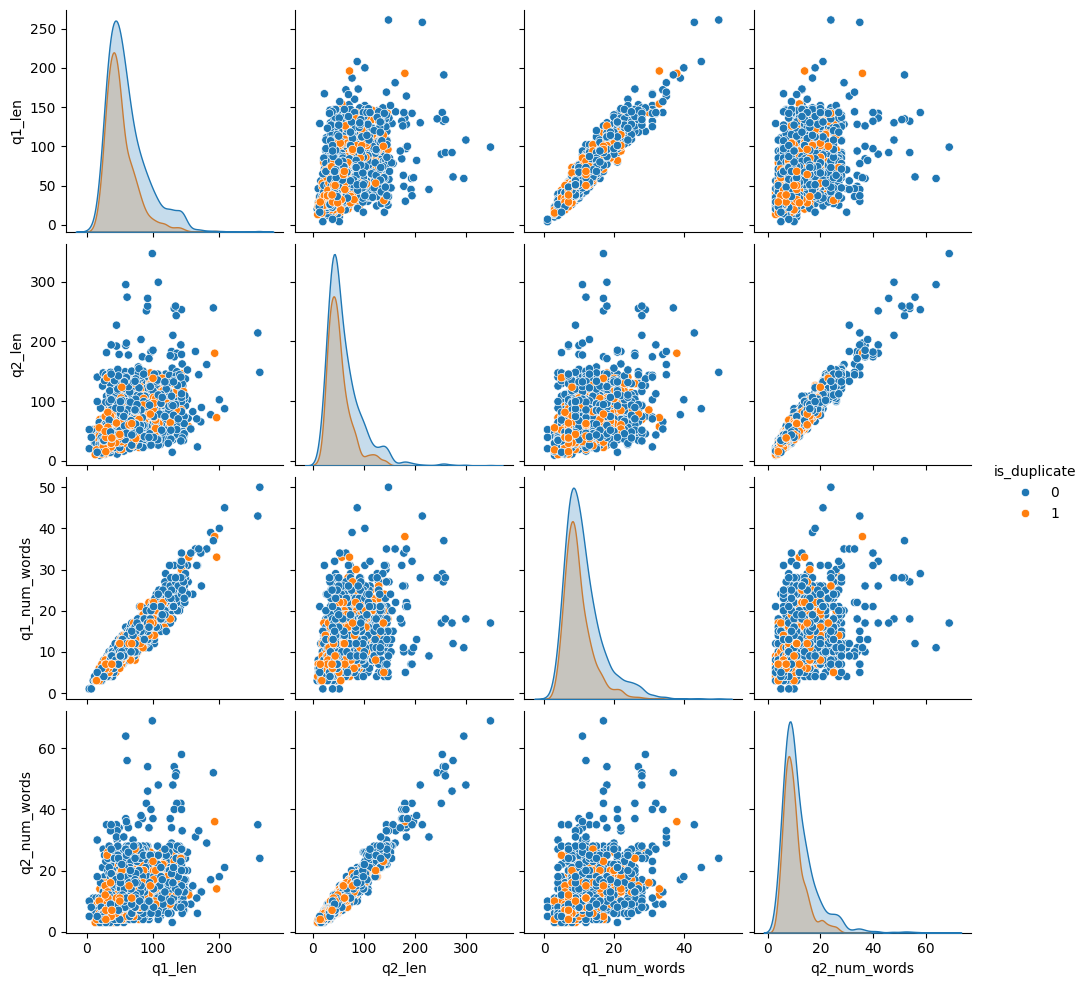

In [ ]:
sns.pairplot(df_temp[['q1_len', 'q2_len', 'q1_num_words', 'q2_num_words','is_duplicate']],hue='is_duplicate')

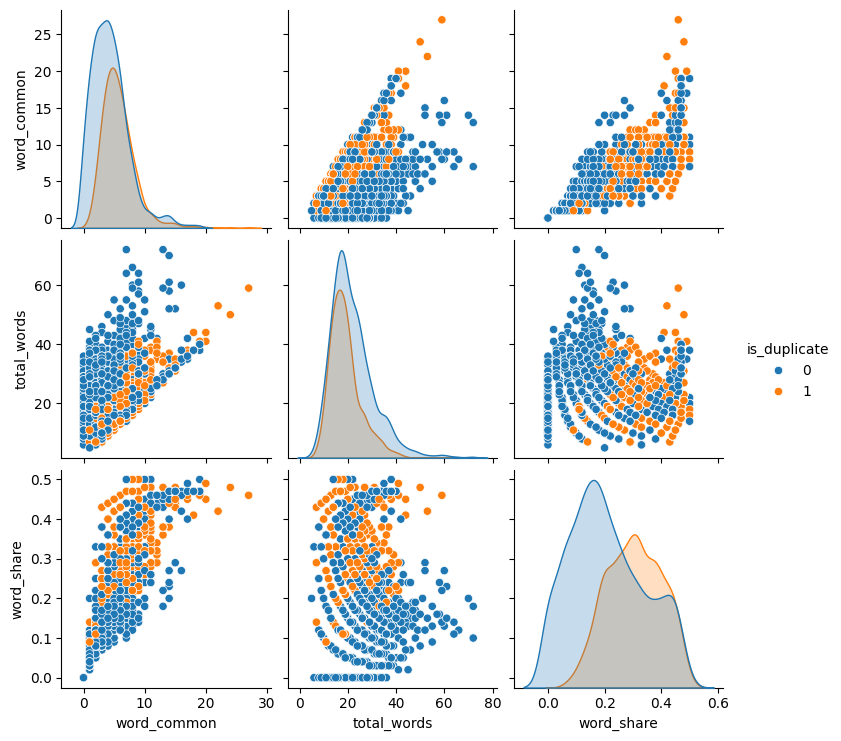

In [ ]:
sns.pairplot(df_temp[['word_common','total_words', 'word_share','is_duplicate']],hue='is_duplicate')

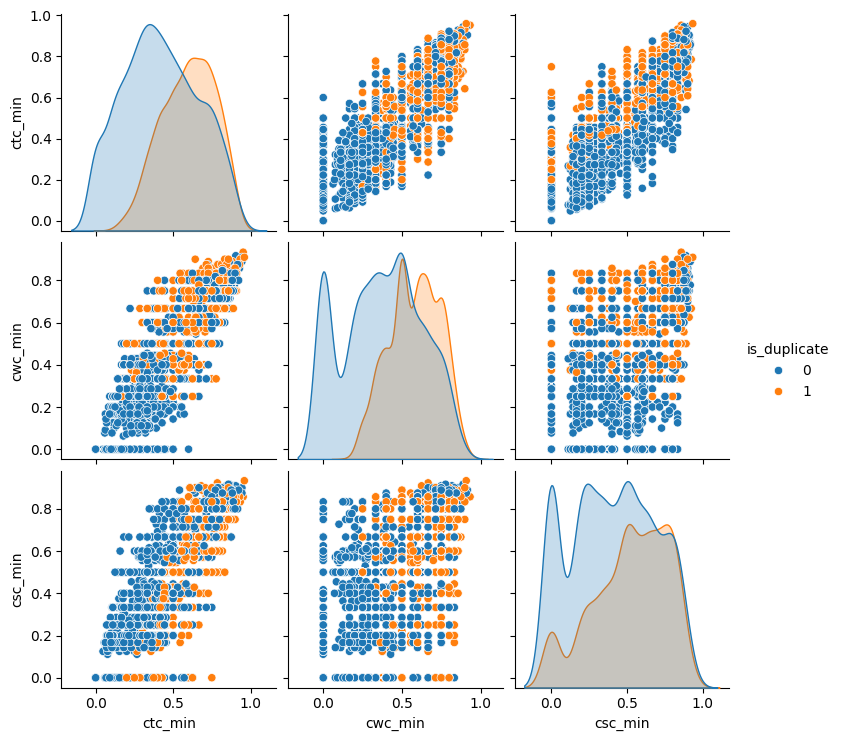

In [ ]:
#EDA to know the  impact of newly created features
sns.pairplot(df_temp[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate')

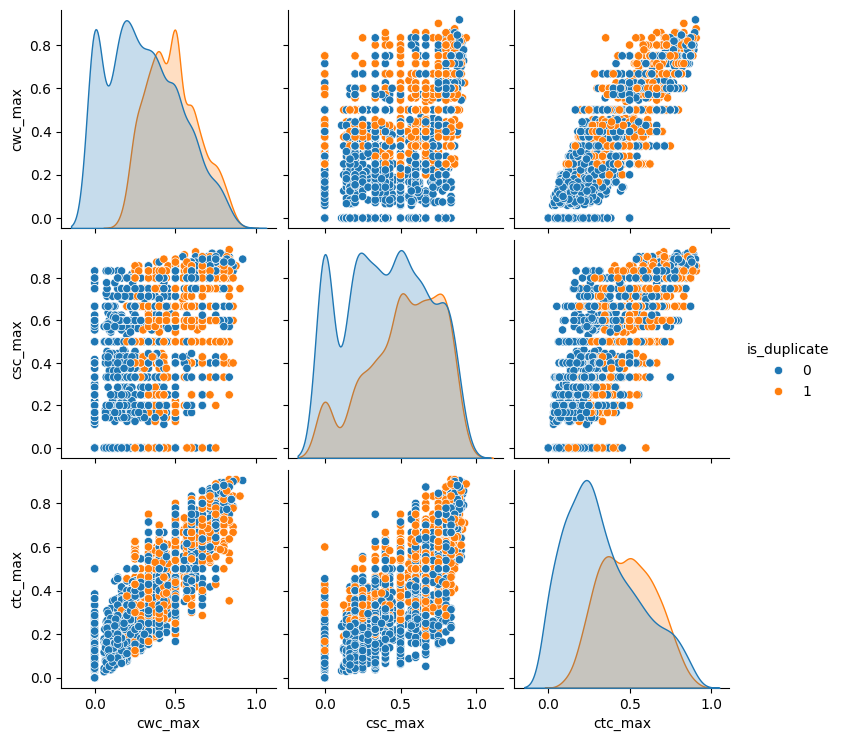

In [ ]:
sns.pairplot(df_temp[['cwc_max', 'csc_max', 'ctc_max','is_duplicate']],hue='is_duplicate')

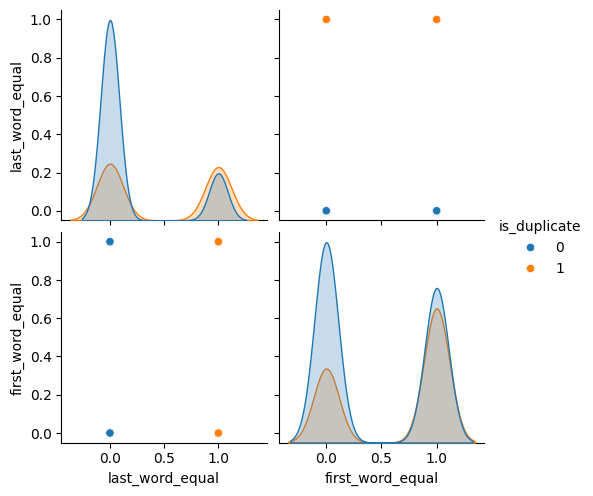

In [ ]:
sns.pairplot(df_temp[['last_word_equal', 'first_word_equal','is_duplicate']],hue='is_duplicate')

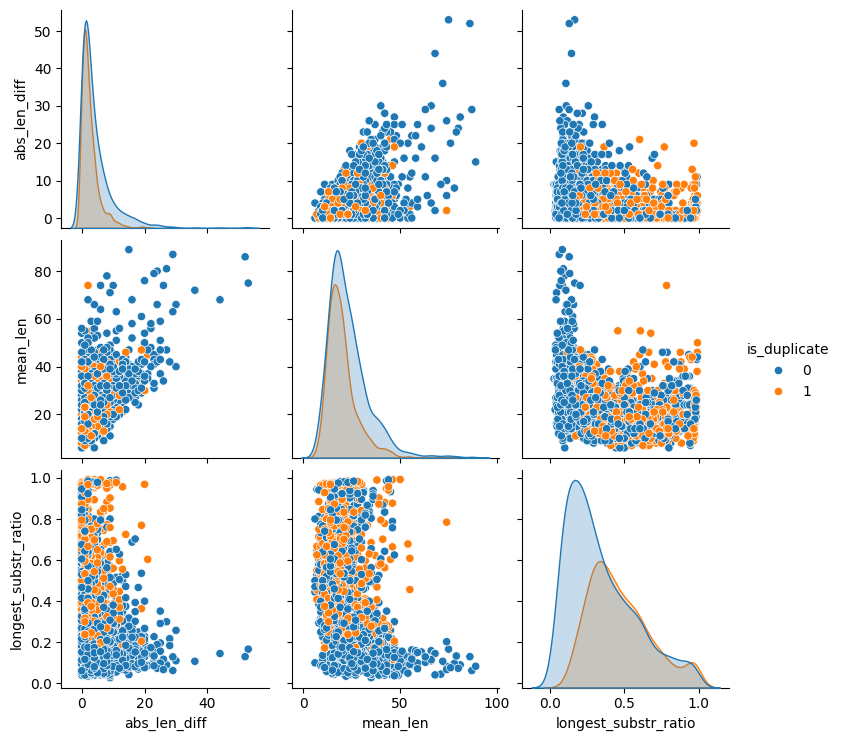

In [ ]:
sns.pairplot(df_temp[['abs_len_diff', 'mean_len', 'longest_substr_ratio','is_duplicate']],hue='is_duplicate')

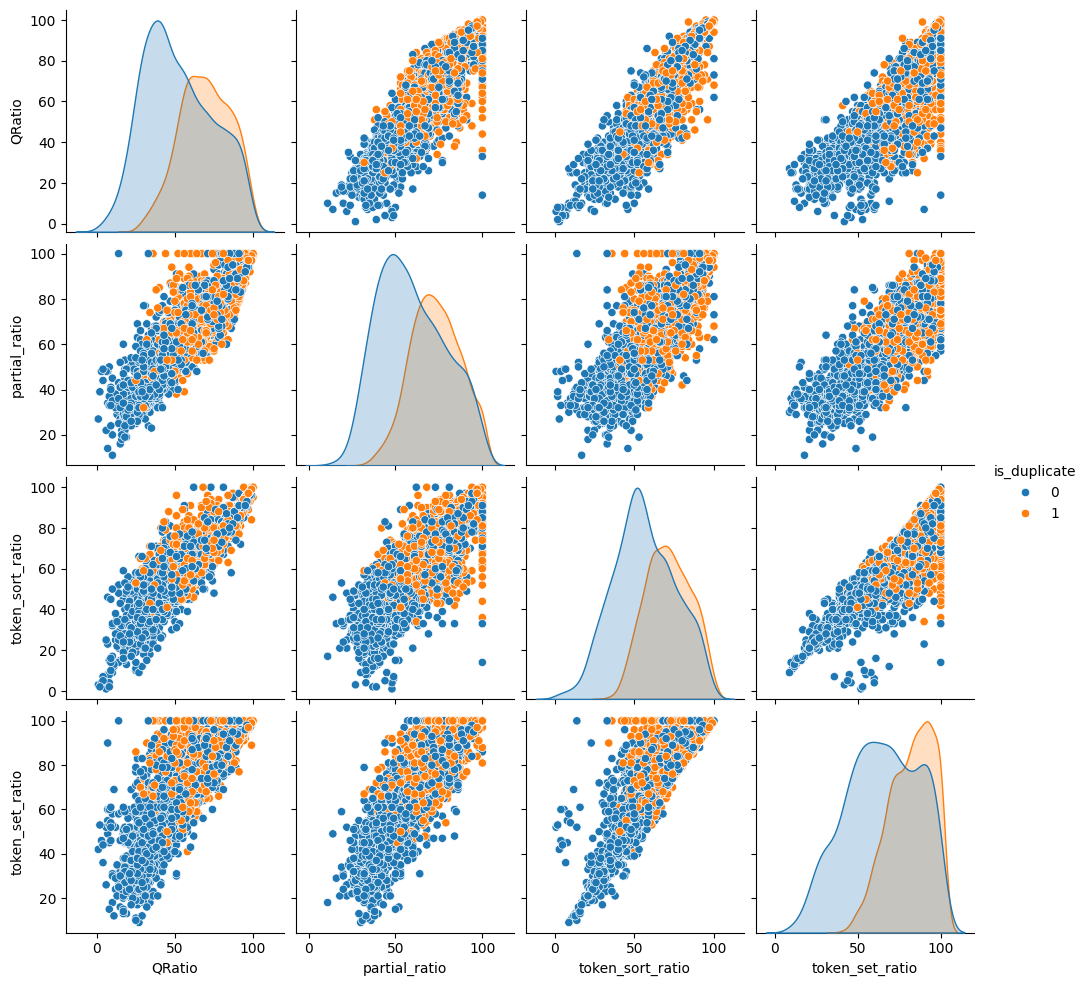

In [ ]:
sns.pairplot(df_temp[['QRatio', 'partial_ratio', 'token_sort_ratio', 'token_set_ratio','is_duplicate']],hue='is_duplicate')

In [37]:
print(x_train_feature.shape,y_train.shape)

(3200, 6022) (3200,)


In [38]:
#feature scalling
mmx = MinMaxScaler()
mmx.fit(x_train_feature)
x_train_scal = mmx.transform(x_train_feature)
x_test_scal  = mmx.transform(x_test_feature)

In [39]:
pd.DataFrame(x_train_scal[:,0:22],columns=['q1_len', 'q2_len', 'q1_num_words', 'q2_num_words', 'word_common','total_words', 'word_share', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_equal', 'first_word_equal', 'abs_len_diff', 'mean_len', 'longest_substr_ratio', 'QRatio' , 'partial_ratio', 'token_sort_ratio', 'token_set_ratio']).describe()

q1_len       q2_len  q1_num_words  q2_num_words  word_common  \
count  3200.000000  3200.000000   3200.000000   3200.000000  3200.000000   
mean      0.170728     0.084614      0.136303      0.081618     0.218709   
std       0.109234     0.057385      0.092623      0.054875     0.136693   
min       0.000000     0.000000      0.000000      0.000000     0.000000   
25%       0.095941     0.047619      0.084746      0.044643     0.130435   
50%       0.143911     0.068783      0.118644      0.062500     0.217391   
75%       0.214022     0.104056      0.169492      0.098214     0.304348   
max       1.000000     1.000000      1.000000      1.000000     1.000000   

       total_words   word_share      cwc_min      cwc_max      csc_min  ...  \
count  3200.000000  3200.000000  3200.000000  3200.000000  3200.000000  ...   
mean      0.193321     0.498594     0.483006     0.394853     0.498686  ...   
std       0.106042     0.258136     0.257158     0.235439     0.283798  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.115385     0.300000     0.303571     0.212500     0.269231  ...   
50%       0.166667     0.500000     0.531250     0.398438     0.538462  ...   
75%       0.243590     0.700000     0.708333     0.531250     0.717949  ...   
max       1.000000     1.000000     1.000000     1.000000     1.000000  ...   

           ctc_max  last_word_equal  first_word_equal  abs_len_diff  \
count  3200.000000      3200.000000        3200.00000   3200.000000   
mean      0.422271         0.311563           0.53125      0.038860   
std       0.238964         0.463204           0.49910      0.051196   
min       0.000000         0.000000           0.00000      0.000000   
25%       0.237037         0.000000           0.00000      0.010309   
50%       0.400000         0.000000           1.00000      0.020619   
75%       0.592593         1.000000           1.00000      0.051546   
max       1.000000         1.000000           1.00000      1.000000   

          mean_len  longest_substr_ratio       QRatio  partial_ratio  \
count  3200.000000           3200.000000  3200.000000    3200.000000   
mean      0.129465              0.380694     0.585306       0.600909   
std       0.078551              0.246283     0.223457       0.215275   
min       0.000000              0.000000     0.000000       0.000000   
25%       0.080000              0.182722     0.404040       0.440341   
50%       0.112000              0.334086     0.585859       0.602273   
75%       0.160000              0.524685     0.767677       0.764205   
max       1.000000              1.000000     1.000000       1.000000   

       token_sort_ratio  token_set_ratio  
count       3200.000000      3200.000000  
mean           0.618759         0.695840  
std            0.195965         0.224672  
min            0.000000         0.000000  
25%            0.484848         0.548387  
50%            0.616162         0.731183  
75%            0.767677         0.881720  
max            1.000000         1.000000  

[8 rows x 22 columns]

In [40]:
# balance data
smote =SMOTE(sampling_strategy='auto',random_state=20,k_neighbors=10)
x_train_bal,y_train_bal = smote.fit_resample(x_train_scal, y_train)

In [41]:
print(x_train_feature.shape,x_train_scal.shape,x_train_bal.shape,y_train_bal.shape)
print(x_test_feature.shape,y_test.shape)

(3200, 6022) (3200, 6022) (3954, 6022) (3954,)
(800, 6022) (800,)


In [42]:
pd.Series(y_train).value_counts()

is_duplicate
0    1977
1    1223
Name: count, dtype: int64

In [43]:
pd.Series(y_train_bal).value_counts()

is_duplicate
1    1977
0    1977
Name: count, dtype: int64

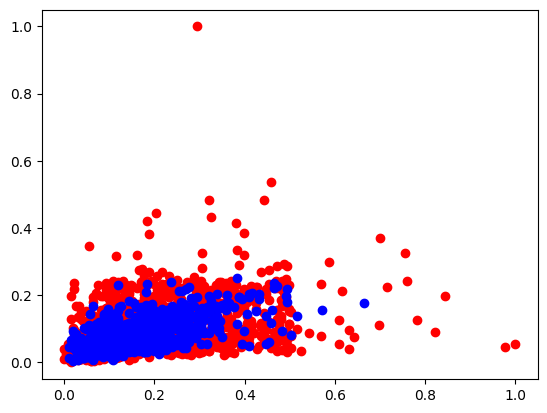

In [44]:
plt.scatter(x_train_bal[y_train_bal==0][:,0],x_train_bal[y_train_bal==0][:,1],color='red')
plt.scatter(x_train_bal[y_train_bal==1][:,0],x_train_bal[y_train_bal==1][:,1],color='blue')
plt.show()

In [45]:
#Hyperparameter tunning
# Define the objective function for Opuna
def objective(trial):
    # Choose the algorithm to tune
    classifier_name = trial.suggest_categorical('classifier', ['SVC', 'RandomForest', 'GradientBoosting','XGBClassifier','DecisionTreeClassifier'])

    if classifier_name == 'SVC':
        # SVM hyperparameters
        c = trial.suggest_float('C', 0.1, 100, log=True)
        kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid'])
        gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

        model = SVC(C=c, kernel=kernel, gamma=gamma, random_state=42)

    elif classifier_name == 'RandomForest':
        # Random Forest hyperparameters
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        max_depth = trial.suggest_int('max_depth', 3, 20)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        bootstrap = trial.suggest_categorical('bootstrap', [True, False])

        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            bootstrap=bootstrap,
            random_state=42
        )

    elif classifier_name == 'XGBClassifier':
        # XGBClassifier hyperparameters
        n_estimators = trial.suggest_int('n_estimators', 50, 300) # Define n_estimators here
        max_depth = trial.suggest_int('max_depth', 3, 20)

        model = XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=42
        )

    elif classifier_name == 'DecisionTreeClassifier':
        # Random Forest hyperparameters
        max_depth = trial.suggest_int('max_depth', 3, 20)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        min_impurity_decrease = trial.suggest_float('min_impurity_decrease', 0.0, 0.5)
        criterion = trial.suggest_categorical('criterion',["gini", "entropy", "log_loss"])

        model = DecisionTreeClassifier(criterion=criterion,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            min_impurity_decrease=min_impurity_decrease,
            random_state=42
        )

    elif classifier_name == 'GradientBoosting':
        # Gradient Boosting hyperparameters
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 20)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

        model = GradientBoostingClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )

    # Perform cross-validation and return the mean accuracy
    score = cross_val_score(model, x_train_bal, y_train_bal, cv=5, scoring='accuracy').mean()
    return score

In [46]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())  # We aim to maximize accuracy
study.optimize(objective, n_trials=10)  # Run 50 trials to find the best hyperparameters

[I 2024-10-09 03:49:25,807] A new study created in memory with name: no-name-49143f8a-8d73-44e6-b1c6-9da04868f2da
[I 2024-10-09 04:29:22,581] Trial 0 finished with value: 0.794655379346765 and parameters: {'classifier': 'GradientBoosting', 'n_estimators': 273, 'learning_rate': 0.04165593919660947, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.794655379346765.
[I 2024-10-09 04:31:06,646] Trial 1 finished with value: 0.6644033349869577 and parameters: {'classifier': 'SVC', 'C': 6.965297365986992, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 0 with value: 0.794655379346765.
[I 2024-10-09 04:31:29,172] Trial 2 finished with value: 0.7582329690025444 and parameters: {'classifier': 'RandomForest', 'n_estimators': 255, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 0 with value: 0.794655379346765.
[I 2024-10-09 04:32:13,220] Trial 3 finished with value: 0.7949107842980364 and parameter

In [47]:
best_trial =study.best_trial
print('Best_trail_Param',best_trial.params)
print('Best_trail_Param',best_trial.values)

Best_trail_Param {'classifier': 'SVC', 'C': 55.27113102035283, 'kernel': 'poly', 'gamma': 'scale'}
Best_trail_Param [0.8373963417561491]


In [ ]:
#Load the best Model

In [ ]:
svc_model = SVC(C=55.27, kernel='poly', gamma='scale', random_state=42)
svc_model.fit(x_train_bal,y_train_bal)
y_pred=svc_model.predict(x_test_scal)

print(classification_report(y_test,y_pred))

score = cross_val_score(svc_model, x_train_bal, y_train_bal, cv=5, scoring='accuracy').mean()

              precision    recall  f1-score   support

           0       0.81      0.79      0.80       521
           1       0.62      0.66      0.64       279

    accuracy                           0.74       800
   macro avg       0.72      0.72      0.72       800
weighted avg       0.75      0.74      0.74       800



In [ ]:
pickle.dump(svc_model,open('svc_model.pkl', 'wb'))
pickle.dump(ngram_cv,open('ngram_cv.pkl','wb'))